# 📦 Clase 8: Artifacts - Manejo de Archivos y Datos Binarios en ADK

## 📘 Tutorial práctico: guarda, versiona y reutiliza resultados

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/)

### 🚀 ¿Qué aprenderás hoy?

En el desarrollo de agentes, a menudo necesitamos generar algo más que texto: reportes PDF, imágenes, archivos CSV grandes o análisis de datos. Aquí es donde entran los **Artifacts**.

1.  **📚 Conceptos Fundamentales**: Diferenciar **state** vs **artifacts**.
2.  **⚙️ Servicios**: Configurar `ArtifactService`.
3.  **🛠️ Operaciones Básicas**: Guardar, cargar y versionar archivos manualmente.
4.  **🤖 Integración con Agentes**: Crear tools que generen PDFs e Imágenes.
5.  **💾 Persistencia**: Introducción a entornos de producción con Google Cloud Storage.

---

### ⚙️ Configuración Inicial

In [58]:
# Instalamos las librerías necesarias
# google-adk: El SDK de agentes
# reportlab: Para generar PDFs de ejemplo
# Pillow: Para manipulación de imágenes
!pip install -qU google-adk==1.22.1 litellm==1.73.0 python-dotenv reportlab Pillow

In [1]:
import os
import sys
from datetime import datetime
from io import BytesIO
from getpass import getpass

# Manipulación de imágenes para visualización
from PIL import Image, ImageDraw

# Generación de PDF
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas

# Google ADK Imports
from google.genai import types
from google.adk.agents import LlmAgent
from google.adk.runners import Runner
from google.adk.sessions import InMemorySessionService
from google.adk.tools.tool_context import ToolContext
from google.adk.artifacts import InMemoryArtifactService

### 🔐 Autenticación

Necesitas una **Google API Key** para usar los modelos Gemini. Si no tienes una, obtenla [aquí](https://aistudio.google.com/).

#### Opcion 1: Ingresalas directamente

In [60]:
# Solicitar API Key de forma segura
if 'GOOGLE_API_KEY' not in os.environ:
    print("🔑 Por favor, ingresa tu Google API Key:")
    api_key = getpass("API Key: ")
    os.environ['GOOGLE_API_KEY'] = api_key
    os.environ['GOOGLE_GENAI_USE_VERTEXAI'] = 'FALSE'
    print("\n✅ API Key configurada correctamente")
else:
    print("✅ API Key ya configurada")

# Verificar que las variables estén configuradas
print(f"\n📋 Variables de entorno configuradas:")
print(f"   - GOOGLE_API_KEY: {'✓' if os.environ.get('GOOGLE_API_KEY') else '✗'}")
print(f"   - GOOGLE_GENAI_USE_VERTEXAI: {os.environ.get('GOOGLE_GENAI_USE_VERTEXAI', 'No configurado')}")

print("✅ ADK instalado y configurado correctamente!")

✅ API Key ya configurada

📋 Variables de entorno configuradas:
   - GOOGLE_API_KEY: ✗
   - GOOGLE_GENAI_USE_VERTEXAI: FALSE
✅ ADK instalado y configurado correctamente!


#### Opcion 2: Cargar por Dotenv

In [2]:
from dotenv import load_dotenv
# Cargar variables de entorno desde .env si existe
load_dotenv(override=True)

True

## 📚 Parte 1: Conceptos Fundamentales de Artifacts

### ¿Qué son los Artifacts?

Los **Artifacts** son objetos gestionados por el ADK para almacenar datos que son demasiado grandes, binarios o complejos para vivir directamente en la memoria o el contexto de la conversación (el `state` o `history`).

### 🆚 State vs Artifacts

| Característica | State (Estado) | Artifacts (Artefactos) |
| :--- | :--- | :--- |
| **Tipo de Dato** | JSON, Strings, Números, Booleanos | Binarios (PDF, PNG), Texto largo, CSVs |
| **Tamaño** | Pequeño (KB) | Grande (MB/GB) |
| **Propósito** | Contexto inmediato, variables de control | Resultados finales, archivos generados |
| **Ubicación** | Memoria / Base de datos de sesión | FileSystem / Google Cloud Storage |
| **Interactividad** | El LLM lo lee directamente | El LLM referencia el nombre/link |

### 💡 ¿Por qué usarlos?

1.  **Evitar Context Window Overflow**: No intentes meter un PDF de 10MB en el prompt.
2.  **Persistencia Organizada**: Guardar versiones de un trabajo (ej. *reporte_v1.pdf*, *reporte_v2.pdf*).
3.  **Intercambio**: Permitir que el usuario descargue el resultado final.

## ⚙️ Parte 2: Servicios de Artifacts (ArtifactService)

El `ArtifactService` es la interfaz que maneja dónde y cómo se guardan estos archivos. En este tutorial usaremos `InMemoryArtifactService` para simplicidad (los datos se pierden al cerrar el script), pero en producción usarías `GcsArtifactService`.

Configuramos también el servicio de sesiones básico.

In [ ]:
# Configuración de servicios en memoria
artifact_service = InMemoryArtifactService()
session_service = InMemorySessionService()

# Identificadores para nuestra app de prueba
APP_NAME = "tutorial_artifacts"
USER_ID = "student_1"
SESSION_ID = "session_demo_01"

session = await session_service.create_session(
    app_name=APP_NAME,
    user_id=USER_ID,
    session_id=SESSION_ID,

)

print("✅ Servicios configurados (In-Memory).")

## 🛠️ Parte 3: Operaciones Básicas

Antes de usar agentes, entendamos cómo interactuar con el servicio directamente usando:
1.  `save_artifact`: Guarda datos.
2.  `load_artifact`: Lee datos.
3.  `list_artifact_versions`: Ve el historial.

El ADK maneja **versionado automático**. Si guardas un archivo con el mismo nombre varias veces, ADK crea nuevas versiones (v0, v1, v2...).

### 📄 Tipos de Datos MIME

Los **MIME types** (Multipurpose Internet Mail Extensions) son identificadores estándar que especifican el tipo de contenido de un archivo. Al trabajar con Artifacts, es crucial usar el MIME type correcto para que el sistema interprete adecuadamente los datos.

#### Tipos MIME Comunes

| MIME Type | Descripción |
| :--- | :--- |
| `text/plain` | Archivos de texto plano (.txt) |
| `application/pdf` | Documentos PDF |
| `image/png` | Imágenes PNG |
| `image/jpeg` | Imágenes JPEG |
| `text/csv` | Archivos CSV |
| `application/json` | Datos JSON |

#### Tipos MIME de Google Workspace

Si trabajas con archivos de Google Drive, estos son los tipos específicos:

| MIME Type | Descripción |
| :--- | :--- |
| `application/vnd.google-apps.document` | Google Docs |
| `application/vnd.google-apps.spreadsheet` | Google Sheets |
| `application/vnd.google-apps.presentation` | Google Slides |
| `application/vnd.google-apps.form` | Google Forms |
| `application/vnd.google-apps.drawing` | Google Drawings |
| `application/vnd.google-apps.folder` | Google Drive folder |
| `application/vnd.google-apps.file` | Google Drive file |
| `application/vnd.google-apps.script` | Google Apps Script |
| `application/vnd.google-apps.site` | Google Sites |
| `application/vnd.google-apps.map` | Google My Maps |
| `application/vnd.google-apps.jam` | Google Jamboard |
| `application/vnd.google-apps.vid` | Google Vids |

💡 **Tip**: Siempre especifica el MIME type correcto al usar `types.Part.from_bytes()` para asegurar que el contenido se maneje apropiadamente.

In [4]:
# 1. Guardemos un archivo de texto simple
texto_contenido = "Este es el contenido de mi primer artifact. ¡Hola ADK!"
datos_bytes = texto_contenido.encode("utf-8")

# Creamos el objeto 'Part' de GenAI (ADK usa tipos de GenAI)
artifact_part = types.Part.from_bytes(data=datos_bytes, mime_type="text/plain")

# Guardamos
filename = "nota_rapida.txt"
version = await artifact_service.save_artifact(
    filename=filename,
    artifact=artifact_part,
    app_name=APP_NAME,
    user_id=USER_ID,
    session_id=SESSION_ID
)

print(f"💾 Guardado: {filename} (Versión: {version})")

💾 Guardado: nota_rapida.txt (Versión: 0)


In [5]:
# 2. Carguemos el archivo para verificar
loaded_artifact = await artifact_service.load_artifact(
    filename=filename,
    version=version, # Puedes especificar la versión o dejarlo null para la última
    app_name=APP_NAME,
    user_id=USER_ID,
    session_id=SESSION_ID
)

if loaded_artifact and loaded_artifact.inline_data:
    contenido_leido = loaded_artifact.inline_data.data.decode("utf-8")
    print(f"📖 Leído: '{contenido_leido}'")

📖 Leído: 'Este es el contenido de mi primer artifact. ¡Hola ADK!'


### 3.1 Demostración de Versionado

Vamos a guardar el mismo archivo varias veces con contenido diferente para ver cómo ADK maneja las versiones.

In [6]:
# Guardamos 3 versiones nuevas
for i in range(1, 4):
    texto = f"Actualización número {i} del reporte."
    part = types.Part.from_bytes(data=texto.encode("utf-8"), mime_type="text/plain")
    v = await artifact_service.save_artifact(filename="reporte_progreso.txt", artifact=part, app_name=APP_NAME, user_id=USER_ID, session_id=SESSION_ID)
    print(f"⬆️ Guardada versión {v}")


⬆️ Guardada versión 0
⬆️ Guardada versión 1
⬆️ Guardada versión 2


In [7]:

# Listamos todas las versiones disponibles
versiones = await artifact_service.list_artifact_versions(filename="reporte_progreso.txt", app_name=APP_NAME, user_id=USER_ID, session_id=SESSION_ID)
print(f"\n📜 Total de versiones encontradas: {len(versiones)}")
for ver in versiones:
    # Nota: 'ver' es un objeto ArtifactVersion
    print(f" - Versión {ver.version} creada en {datetime.fromtimestamp(ver.create_time).strftime('%H:%M:%S')}")


📜 Total de versiones encontradas: 3
 - Versión 0 creada en 12:58:36
 - Versión 1 creada en 12:58:36
 - Versión 2 creada en 12:58:36


## 🤖 Parte 4: Generación de Artifacts desde Tools

Ahora lo interesante: darle a un Agente la capacidad de crear archivos. Para esto, creamos **Tools** (funciones Python) que:
1.  Reciben instrucciones del agente.
2.  Generan el contenido (PDF, Imagen, etc.).
3.  Guardan el artifact usando `tool_context.save_artifact`.
4.  Devuelven al agente el **nombre del archivo** (no el contenido binario).

### Definición de Tools

In [8]:
async def generar_reporte_pdf(tool_context: ToolContext, titulo: str, contenido_cuerpo: str) -> dict:
    """
    Genera un archivo PDF con un título y cuerpo de texto.
    Retorna el nombre del archivo generado.
    """
    print(f"   ⚙️ [Tool] Generando PDF: '{titulo}'...")
    try:
        # 1. Crear PDF en memoria
        buffer = BytesIO()
        c = canvas.Canvas(buffer, pagesize=letter)
        width, height = letter
        
        # Título
        c.setFont("Helvetica-Bold", 20)
        c.drawString(50, height - 50, titulo)
        
        # Cuerpo
        c.setFont("Helvetica", 12)
        # Simple wrap manual para demo
        y_pos = height - 100
        for linea in contenido_cuerpo.split('\n'):
            c.drawString(50, y_pos, linea)
            y_pos -= 15
            
        c.save()
        pdf_bytes = buffer.getvalue()
        buffer.close()

        # 2. Guardar como Artifact
        # Nombre único con timestamp
        filename = f"reporte_{datetime.now().strftime('%M%S')}.pdf"
        artifact_part = types.Part.from_bytes(data=pdf_bytes, mime_type="application/pdf")
        
        # ADK inyecta el 'tool_context' automáticamente
        version = await tool_context.save_artifact(filename, artifact_part)
        
        # 3. Guardar referencia en el 'state' para que el agente recuerde qué hizo
        tool_context.state["ultimo_pdf"] = filename

        return {
            "status": "success", 
            "filename": filename, 
            "version": version, 
            "mensaje": "PDF generado correctamente. Dile al usuario que puede descargarlo."
        }

    except Exception as e:
        return {"status": "error", "error": str(e)}


async def generar_imagen_estadistica(tool_context: ToolContext, etiqueta: str, valor: str) -> dict:
    """
    Crea una imagen simple mostrando un dato estadístico clave.
    """
    print(f"   ⚙️ [Tool] Generando Imagen: {etiqueta}={valor}...")
    try:
        # 1. Crear Imagen
        img = Image.new('RGB', (400, 200), color = (73, 109, 137))
        d = ImageDraw.Draw(img)
        
        # Texto (simulado centrado)
        d.text((50, 80), f"{etiqueta}: {valor}", fill=(255, 255, 0))
        
        buffer = BytesIO()
        img.save(buffer, format="PNG")
        img_bytes = buffer.getvalue()
        
        # 2. Guardar Artifact
        filename = f"image_{datetime.now().strftime('%M%S')}.png"
        artifact_part = types.Part.from_bytes(data=img_bytes, mime_type="image/png")
        version = await tool_context.save_artifact(filename, artifact_part)

        return {"filename": filename, "status": "success", "version": version}

    except Exception as e:
        return {"status": "error", "error": str(e)}

## 🔄 Parte 5: Integración con Agentes

Configuramos un `LlmAgent` con acceso a estas herramientas. Notarás que el agente **no ve los bytes**, solo recibe el nombre del archivo y confirma la creación al usuario.

In [9]:
agente_creativo = LlmAgent(
    name="AgenteCreador",
    model="gemini-3-flash-preview",
    instruction=(
        "Eres un asistente administrativo experto. "
        "Tu trabajo es generar reportes y visualizaciones cuando el usuario lo pida. "
        "Usa las herramientas disponibles. Cuando generes un archivo, informa al usuario el nombre exacto del archivo generado."
    ),
    tools=[generar_reporte_pdf, generar_imagen_estadistica]
)

# Importante: Pasamos el 'artifact_service' al Runner
runner = Runner(
    agent=agente_creativo,
    app_name=APP_NAME,
    session_service=session_service,
    artifact_service=artifact_service
)

print(f"🤖 Agente '{agente_creativo.name}' listo con {len(agente_creativo.tools)} herramientas.")

🤖 Agente 'AgenteCreador' listo con 2 herramientas.


### Helper de Ejecución
Usamos una función auxiliar para enviar mensajes y ver la respuesta.

In [10]:
async def call_agent_async(query: str, runner: Runner, user_id: str, session_id: str) -> str:
    """Envía un mensaje al agente y devuelve la respuesta final de texto."""
    print(f"\n🧑‍💻 Usuario: {query}")
    content = types.Content(role="user", parts=[types.Part(text=query)])

    final_response_text = "El agente no produjo una respuesta final."

    async for event in runner.run_async(user_id=user_id, session_id=session_id, new_message=content):
        if event.is_final_response():
            if event.content and event.content.parts:
                final_response_text = event.content.parts[0].text
            break

    print(f"🤖 Agente: {final_response_text}\n")
    return final_response_text

### 🧪 Probando el Agente

In [11]:
# Prueba 1: Generar un PDF
await call_agent_async("Necesito un reporte PDF titulado 'Ventas Q1' que diga: 'Las ventas subieron un 20% respecto al año anterior'.", runner, USER_ID, SESSION_ID)

# Prueba 2: Generar una Imagen
await call_agent_async("Genera una imagen que muestre el dato: 'Crecimiento' con valor '20%'", runner, USER_ID, SESSION_ID)


🧑‍💻 Usuario: Necesito un reporte PDF titulado 'Ventas Q1' que diga: 'Las ventas subieron un 20% respecto al año anterior'.


/Users/alarcon7a/anaconda3/envs/python3/lib/python3.11/site-packages/google/adk/flows/llm_flows/base_llm_flow.py:449: UserWarning: [EXPERIMENTAL] feature FeatureName.PROGRESSIVE_SSE_STREAMING is enabled.
  async for event in agen:


   ⚙️ [Tool] Generando PDF: 'Ventas Q1'...
🤖 Agente: OK. He generado el reporte solicitado. El archivo se llama **reporte_0224.pdf**. Ya puedes descargarlo.


🧑‍💻 Usuario: Genera una imagen que muestre el dato: 'Crecimiento' con valor '20%'
   ⚙️ [Tool] Generando Imagen: Crecimiento=20%...
🤖 Agente: He generado la imagen con el dato solicitado. El archivo se llama **image_0228.png**.



'He generado la imagen con el dato solicitado. El archivo se llama **image_0228.png**.'

### 🖼️ Visualizando el Resultado

Como estamos en un notebook, ¡podemos recuperar el artifact generado y mostrarlo aquí mismo! El agente nos dijo el nombre del archivo (o lo guardamos en `state`), vamos a buscar el último generado.

In [12]:
filename = 'reporte_0224.pdf'
all_versions = await artifact_service.list_artifact_versions(
    filename=filename, # Listar todo (si el servicio lo soporta) o iteramos nombres conocidos
    app_name=APP_NAME, user_id=USER_ID, session_id=SESSION_ID
)
all_versions

[ArtifactVersion(version=0, canonical_uri='memory://apps/tutorial_artifacts/users/student_1/sessions/session_demo_01/artifacts/reporte_0224.pdf/versions/0', custom_metadata={}, create_time=1768327344.847783, mime_type='application/pdf')]

In [13]:

# 2. Carguemos el archivo para verificar
loaded_artifact = await artifact_service.load_artifact(
    filename=filename,
    version=None, # Puedes especificar la versión o dejarlo null para la última
    app_name=APP_NAME,
    user_id=USER_ID,
    session_id=SESSION_ID
)

loaded_artifact
if loaded_artifact and loaded_artifact.inline_data:
    pdf_data = loaded_artifact.inline_data.data
    # Guardar temporalmente para mostrar
    temp_pdf_path = "temp_reporte.pdf"
    with open(temp_pdf_path, "wb") as f:
        f.write(pdf_data)   


In [14]:
keys = await artifact_service.list_artifact_keys(
            app_name=APP_NAME, user_id=USER_ID, session_id=SESSION_ID
        )
keys


['image_0228.png',
 'nota_rapida.txt',
 'reporte_0224.pdf',
 'reporte_progreso.txt']

🔎 Encontrado artifact de imagen: image_0228.png


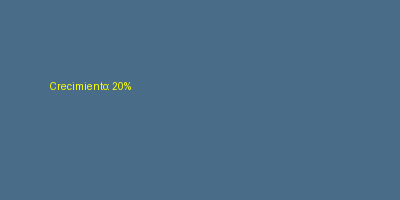

In [15]:
# Visualización del Resultado (Corregido)

# Buscamos el último artifact generado usando 'list_artifact_versions'
# El agente nos dio el nombre del archivo en 'final_response_text' o podemos buscarlo en el estado.

import IPython.display

try:
    # 1. Intentamos obtener el nombre desde el estado del agente (si lo guardamos en la tool)
    # Nota: El Runner no expone el state directamente fuera, pero podemos listar los archivos.
    
    # En ADK 1.22.1+, list_artifact_versions requiere un filename. 
    # Para listar TODOS los archivos de una sesión, usamos list_artifact_keys (si está disponible)
    # o simplemente confiamos en el nombre que el agente nos dio por chat.
    
    # Vamos a usar un enfoque más robusto: buscar el último PDF o PNG generado
    # Si sabes el nombre exacto (ej. desde el chat), es mejor usarlo directamente.
    
    # Como truco para este notebook, vamos a intentar listar las llaves si el servicio lo permite:
    if hasattr(artifact_service, 'list_artifact_keys'):
        keys = await artifact_service.list_artifact_keys(
            app_name=APP_NAME, user_id=USER_ID, session_id=SESSION_ID
        )
        png_files = [k for k in keys if k.endswith('.png')]
        if png_files:
            ultimo_png = png_files[-1]
            print(f"🔎 Encontrado artifact de imagen: {ultimo_png}")
            art = await artifact_service.load_artifact(filename=ultimo_png, app_name=APP_NAME, user_id=USER_ID, session_id=SESSION_ID)
            if art:
                display(IPython.display.Image(data=art.inline_data.data))
        else:
            print("⚠️ No se encontraron imágenes PNG en la sesión.")
    else:
        # Si no podemos listar, intentamos recuperar el nombre del estado si estuviera disponible
        # o simplemente recordamos que en la celda anterior imprimimos el nombre.
        print("💡 Tip: Para ver la imagen, usa art = await artifact_service.load_artifact('NOMBRE_DEL_ARCHIVO', ...)")
        print("El nombre aparece en el log del agente arriba (ej: stats_1234.png)")

except Exception as e:
    print(f"❌ Error al visualizar: {e}")


## 💾 Parte 6: Persistencia y Producción

El `InMemoryArtifactService` es genial para pruebas, pero si reinicias el kernel, pierdes todo. Para aplicaciones reales, usa **Google Cloud Storage (GCS)**.

Para implementarlo, solo cambias una línea en la configuración del Runner:

```python
from google.adk.artifacts import GcsArtifactService

# Requiere credenciales de GCP configuradas en el entorno
# artifact_service = GcsArtifactService(bucket_name="alarcon_agent_bucket")
```

El ADK se encargará de subir y bajar los archivos de GCS transparentemente.

In [16]:
from google.adk.artifacts import GcsArtifactService

# Specify the GCS bucket name
gcs_bucket_name_py ="alarcon_agent_bucket" # <--- CAMBIA ESTO por un bucket que te pertenezca
APP_NAME_PERSISTENT = "tutorial_artifacts_persistent"
USER_ID_PERSISTENT = "student_2"
SESSION_ID_PERSISTENT = "session_demo_02"

session_persistent = await session_service.create_session(
    app_name=APP_NAME_PERSISTENT,
    user_id=USER_ID_PERSISTENT,
    session_id=SESSION_ID_PERSISTENT,
)

try:
    gcs_service_py = GcsArtifactService(bucket_name=gcs_bucket_name_py)
    print(f"Python GcsArtifactService initialized for bucket: {gcs_bucket_name_py}")
    
    agente_creador = LlmAgent(
        name="AgenteCreador",
        model="gemini-3-flash-preview",
        instruction=(
            "Eres un asistente administrativo experto. "
            "Tu trabajo es generar reportes y visualizaciones cuando el usuario lo pida. "
            "Usa las herramientas disponibles. Cuando generes un archivo, informa al usuario el nombre exacto del archivo generado."
        ),
        tools=[generar_reporte_pdf, generar_imagen_estadistica]
    )

    # Importante: Pasamos el 'artifact_service' al Runner
    runner_persistent = Runner(
        agent=agente_creador,
        app_name=APP_NAME_PERSISTENT,
        session_service=session_service,
        artifact_service=gcs_service_py
    )

    print(f"🤖 Agente '{agente_creador.name}' listo con {len(agente_creador.tools)} herramientas.")

except Exception as e:
    print(f"Error initializing Python GcsArtifactService: {e}")


Python GcsArtifactService initialized for bucket: alarcon_agent_bucket
🤖 Agente 'AgenteCreador' listo con 2 herramientas.


In [17]:
## login on gcp 
import google.auth
credentials, project = google.auth.default()

In [18]:
# Prueba 1: Generar un PDF
await call_agent_async("Genera un reporte PDF titulado 'Ventas Q1' que diga: 'Las ventas subieron un 20% respecto al año anterior'.", runner_persistent, USER_ID_PERSISTENT, SESSION_ID_PERSISTENT)

# Prueba 2: Generar una Imagen
await call_agent_async("Genera una imagen que muestre el dato: 'Crecimiento' con valor '20%'", runner_persistent, USER_ID_PERSISTENT, SESSION_ID_PERSISTENT)


🧑‍💻 Usuario: Genera un reporte PDF titulado 'Ventas Q1' que diga: 'Las ventas subieron un 20% respecto al año anterior'.
   ⚙️ [Tool] Generando PDF: 'Ventas Q1'...
🤖 Agente: El reporte PDF ha sido generado exitosamente con el título 'Ventas Q1'. El nombre del archivo es `reporte_1055.pdf` y ya puedes descargarlo.


🧑‍💻 Usuario: Genera una imagen que muestre el dato: 'Crecimiento' con valor '20%'
   ⚙️ [Tool] Generando Imagen: Crecimiento=20%...
🤖 Agente: He generado la imagen con el dato solicitado. El nombre del archivo es `image_1059.png`.



'He generado la imagen con el dato solicitado. El nombre del archivo es `image_1059.png`.'

## 📖 Parte 8: Consumo de Artifacts (El Agente lee archivos)

Hasta ahora el agente ha *creado* archivos. Pero, ¿qué pasa si el usuario sube un archivo y queremos que el agente lo analice?

El flujo es:
1.  **Carga**: El archivo se registra en el `ArtifactService`.
2.  **Tool de Lectura**: Creamos una herramienta que use `tool_context.load_artifact` para obtener el contenido.
3.  **Análisis**: El agente recibe el texto del archivo y responde.

In [19]:
async def leer_documento_pdf(tool_context: ToolContext, filename: str) -> dict:
    """
    Lee el contenido de un documento PDF guardado como artifact.
    Retorna un resumen o el contenido textual para el agente.
    """
    print(f"   ⚙️ [Tool] Leyendo documento: {filename}...")
    try:
        # 1. Cargar el artifact usando el context
        artifact = await tool_context.load_artifact(filename)
        
        if not artifact:
            return {"status": "error", "message": "Archivo no encontrado"}
        
        # 2. Extraer datos (En una app real usarías pypdf para archivos binarios)
        # Para este tutorial, asumimos que podemos decodificarlo como texto
        contenido = artifact.inline_data.data.decode("utf-8")
        
        return {
            "status": "success",
            "contenido": contenido[:1000],  # Limitamos para no saturar el contexto
            "nota": "Se muestran los primeros 1000 caracteres."
        }
    except Exception as e:
        return {"status": "error", "error": str(e)}

In [20]:
# Actualizamos el agente para incluir la nueva capacidad de lectura
agente_creativo.tools = [generar_reporte_pdf, generar_imagen_estadistica, leer_documento_pdf]

runner = Runner(
    agent=agente_creativo,
    app_name=APP_NAME,
    session_service=session_service,
    artifact_service=artifact_service
)

print("✅ Agente re-configurado con 3 herramientas (Generación + Lectura).")

✅ Agente re-configurado con 3 herramientas (Generación + Lectura).


In [21]:
# 1. Simulamos que el usuario sube un archivo 'datos_secretos.pdf'
contenido_archivo = "REPORTE CONFIDENCIAL: El código de acceso a la bóveda es ADK-2026."
parte_pdf = types.Part.from_bytes(data=contenido_archivo.encode("utf-8"), mime_type="application/pdf")

# Guardamos manualmente en el servicio
await artifact_service.save_artifact(
    filename="datos_secretos.pdf", 
    artifact=parte_pdf, 
    app_name=APP_NAME, user_id=USER_ID, session_id=SESSION_ID
)

print("📤 Archivo 'datos_secretos.pdf' subido exitosamente.\n")

# 2. Le preguntamos al agente
await call_agent_async("¿Cuál es el código de acceso que aparece en el archivo 'datos_secretos.pdf'?", runner, USER_ID, SESSION_ID)

📤 Archivo 'datos_secretos.pdf' subido exitosamente.


🧑‍💻 Usuario: ¿Cuál es el código de acceso que aparece en el archivo 'datos_secretos.pdf'?
   ⚙️ [Tool] Leyendo documento: datos_secretos.pdf...
🤖 Agente: El código de acceso que aparece en el archivo **datos_secretos.pdf** es **ADK-2026**.



'El código de acceso que aparece en el archivo **datos_secretos.pdf** es **ADK-2026**.'

## 🎓 Parte 7: Resumen

¡Felicidades! Has aprendido a manejar **Artifacts** en ADK. 

**Puntos Clave:**
1.  Usa **Artifacts** para archivos binarios o grandes, no el State.
2.  Los agentes interactúan con **referencias (nombres)** a los archivos, no con los bytes.
3.  Usa `ArtifactService` para abstraer el almacenamiento (Memoria vs Cloud).
4.  Las **Tools** son el puente: crean el contenido y lo registran en el servicio.

---
**Siguiente Clase:** Context Management - Cómo manejar ventanas de contexto limitadas eficientemente.